# A basic training loop

We will progressively work through several different ways to run a training loop on a basic neural net on the MNIST data set.  We will begin with a version that is primarily in pure Python, and then incrementally add more PyTorch functionality.  Using PyTorch modules and methods will make our code more readable, flexible, and easier to use.  The goal of this notebook is to illustrate the usefulness of PyTorch, and how to use it when training a neural net.

Please note, we will import modules and methods directly before we use them (even though this is not the standard way of writing production code) since we want to make it clear **when** we are using various modules, and what the minimal amount of code needed is at each point.

## MNIST data setup

We will use [pathlib](https://docs.python.org/3/library/pathlib.html), the recommended way for dealing with paths in Python 3 and part of the Python 3 standard library.

In [1]:
from pathlib import Path

DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

We download the MNIST dataset, a classic dataset consisting of black-and-white images hand-drawn digits (between 0 and 9).

In [2]:
import requests

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

Although our dataset consists of images, they have been stored using pickle, a python-specific format for compressing data sets.

In [3]:
import pickle, gzip

with gzip.open(PATH/FILENAME, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

It is always a good idea to take a look at your data to make sure it is what you expect it to be.  Here, our training set consists of 50,000 images.  Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28)

In [4]:
x_train.shape

(50000, 784)

We can use matplotlib and numpy to display the first image in our training set:

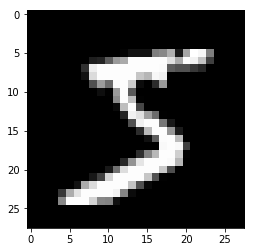

In [8]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(np.reshape(x_train[0], (28,28)), cmap="gray")

Now we will import PyTorch.  We will be storing our data as *tensors*.  You can think of a *tensor* as a multidimensional matrix.  The PyTorch data type tensor is also capable of storing what actions were performed on the data (which is information we will need to calculate gradients later on!)

In [9]:
import torch 

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))

In [10]:
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

## Basic model and training loop

Now that our data is loaded as a tensor, we are ready to create a model!  A model is just a function.  In this case, we will multiply our input by the weights (remember that @ can be used for matrix multiplication in Python 3) and add a set of constants (called the bias).  We then take the log of the softmax.

We will use the torch.nn.functional module

In [44]:
import torch.nn.functional as F

def model(xb):
    xb = (xb @ weights) + bias
    return F.log_softmax(xb, dim=-1)

bs stands for batch size. [Here is a reference](https://github.com/fastai/fastai_v1/blob/master/docs/abbr.md]) for this and other abbreviations used as variable names. (And [here is an explanation](https://github.com/fastai/fastai/blob/master/docs/style.md) of the fast.ai style guide which favors more concise programming than PEP 8)

In [45]:
bs=64

We will call the function `model` on one batch of data (in this case, 64 images).  This is one *forward pass*.  Note that our predictions won't be very good.

In [46]:
preds = model(x_train[0:bs])
preds[0], preds.shape

(tensor([-2.6984, -2.4446, -2.0079, -2.0764, -2.3291, -2.9882, -2.2217, -1.8862,
         -2.3404, -2.4991], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [47]:
loss_fn = F.nll_loss

In [48]:
loss_fn(preds, y_train[0:bs])

tensor(2.4069, grad_fn=<NllLossBackward>)

In [49]:
lr = 0.5
epochs = 2

In [50]:
from IPython.core.debugger import set_trace

In [51]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [52]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2296, grad_fn=<NllLossBackward>)

## Refactor using nn.Module

Now we will try and build the model in a smarter way, by using Pytorch's *nn.Module*. We will define a class for our model that includes the same operations as our previous model function but using Pytorch functions.

In [16]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        xb = (xb @ self.weights) + self.bias
        return F.log_softmax(xb, dim=-1)

In [17]:
model = Mnist_Logistic()

In [18]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(2.3110, grad_fn=<NllLossBackward>)

In [19]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [20]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2300, grad_fn=<NllLossBackward>)

## Refactor using nn.Linear

It turns out that we don't need to manually define the forward operation *features*weights + bias* before feeding into softmax. There is a Pytorch class for this called [nn.Linear](https://pytorch.org/docs/stable/nn.html). 

Next, we replace our previous manual operation by the nn.Linear class, with similar results.

In [21]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)

    def forward(self, xb):
        return F.log_softmax(self.lin(xb), dim=-1)

In [22]:
model = Mnist_Logistic()
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(2.2636, grad_fn=<NllLossBackward>)

In [23]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters(): p -= p.grad * lr
            model.zero_grad()

In [24]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2256, grad_fn=<NllLossBackward>)

## Refactor using optim

Pytorch also has a package with various optimization algorithms. This means we don't have to manually perform the operations in our optimizer; we can use *torch.optim*.

Next, we replace our manual operations for stochastic gradient descent using *optim.SGD()*. 

Note that we need to perform two operations:
1. *optim.step()* function performs an update on the model's parameters according to our optimizer of choice.
2. *optim.zero_grad()* resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch. (*.backward()* by default accumulates the gradient over minibatches).

In [25]:
from torch import optim

In [26]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(2.3184, grad_fn=<NllLossBackward>)

In [27]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [28]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2272, grad_fn=<NllLossBackward>)

## Refactor using Dataset

Now we use Pytorch's TensorDataset function to build a training dataset.

TensorDataset is a Pytorch utility class that implements the Pytorch Dataset API for a given list of tensors. The Dataset API allows iteration, indexing and slicing along the first dimension of each tensor passed in. This makes it easy to access both the features and target in the same line as we train.

In case you aren't already familiar with the Pytorch Dataset class, [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) talks about the Dataset abstract class, how to use it, and how to implement custom datasets for new kinds of data.

In [29]:
from torch.utils.data import TensorDataset

In [30]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=1.)

In [31]:
train_ds = TensorDataset(x_train, y_train)

In [32]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [33]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2200, grad_fn=<NllLossBackward>)

## Refactor using DataLoader

Finally, we use Pytorch's DataLoader to easily iterate over our dataset's minibatches as we train.

In [34]:
from torch.utils.data import DataLoader

In [35]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [36]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [37]:
for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [38]:
loss_fn(model(x_train[0:bs]), y_train[0:bs])

tensor(0.2276, grad_fn=<NllLossBackward>)

# Add validation

Next, we will add a validation set for our training.

A few things to note here. 

First, in this scenario we shuffle the training data but not the validation data. Shuffling the training data is [very important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks) to prevent correlation between batches and overfitting. On the other hand, the validation set is not used for training, only for calculating the loss. The validation loss will be identical whether we shuffle or not and thus it makes no sense to shuffle the validation data.

Second, the batch size for the validation set is twice as large as the training set's. This is [because](http://forums.fast.ai/t/why-is-batch-size-doubled-for-val-batches/720) the validation set does not need backpropagation and thus takes less memory (it doesn't need to remember the gradients). Obviously, we take advantage of this to use a larger batch size and compute the loss more quickly.

## First try

In [39]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [40]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

In [41]:
loss_fn(model(x_valid[0:bs]), y_valid[0:bs])

tensor(2.3835, grad_fn=<NllLossBackward>)

In [42]:
for epoch in range(epochs):
    model.train()
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(xb), yb)
                         for xb,yb in valid_dl)

    print(epoch, valid_loss/len(valid_dl))

0 tensor(0.2931)
1 tensor(0.2919)


## Create fit() and get_data()

Now we will create some functions that we will use over and over again when we train models.

With *get_data* we return two dataloaders for the training and validation sets with the aforementioned characteristics.

With *fit* we run the necessary operations to train our model and compute the training and validation losses for each epoch.

In [43]:
def loss_batch(model, loss_fn, xb, yb, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [44]:
import numpy as np

def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: loss_batch(model, loss_fn, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, loss_fn, xb, yb)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

In [45]:
def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))

train_dl,valid_dl = get_data(train_ds, valid_ds, bs)

In [47]:
model = Mnist_Logistic()
opt = optim.SGD(model.parameters(), lr=lr)

In [48]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.32389578552246095
1 0.3008082551002502


# Switch to CNN

We are now going to build our neural network with three convolutional layers. Since our previous attempt at a neural network was just a simple one linear layer network, we expect a better result (lower loss) in this attempt. 

We will use Pytorch's predifined [Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) function as our convolutional layer. 

## First try

In [49]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        xb = xb.view(-1,xb.size(1))
        return F.log_softmax(xb, dim=-1)

In [50]:
lr=0.2

In [51]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr)

In [52]:
xb, yb = next(iter(valid_dl))
loss_fn(model(xb), yb)

tensor(2.3029, grad_fn=<NllLossBackward>)

In [53]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 0.9714147342681885
1 0.42008232226371767


## nn.Sequential

Finally, we will integrate all the neural network's operations into a [Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) object. A Sequential object basically runs each of the functions contained within it, in a sequential manner. This is a simpler way of writing our neural network.

In [54]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
        
    def forward(self, x): return self.func(x)

In [55]:
model = nn.Sequential(
    Lambda(lambda x: x.view(-1,1,28,28)),
    nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0),-1)),
    nn.LogSoftmax(-1),
)

In [56]:
opt = optim.SGD(model.parameters(), lr=lr)

In [57]:
xb, yb = next(iter(valid_dl))
loss_fn(model(xb), yb)

tensor(2.3019, grad_fn=<NllLossBackward>)

In [58]:
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 1.1196507553100585
1 0.7486707862377167
